# Zero-shot Image Classification with SigLIP

[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/openvinotoolkit/openvino_notebooks/blob/main/notebooks/281-siglip-zero-shot-image-classification/281-siglip-zero-shot-image-classification.ipynb)

Zero-shot image classification is a computer vision task to classify images into one of several classes without any prior training or knowledge of the classes.

![zero-shot-pipeline](https://user-images.githubusercontent.com/29454499/207773481-d77cacf8-6cdc-4765-a31b-a1669476d620.png)

[**image source*](https://huggingface.co/tasks/zero-shot-image-classification)


Zero-shot learning resolves several challenges in image retrieval systems. For example, with the rapid growth of categories on the web, it is challenging to index images based on unseen categories. We can associate unseen categories to images with zero-shot learning by exploiting attributes to model's relationship between visual features and labels.
In this tutorial, we will use the [SigLIP](https://huggingface.co/docs/transformers/main/en/model_doc/siglip) model to perform zero-shot image classification.

#### Table of contents:
- [Instantiate model](#Instantiate-model)
- [Run PyTorch model inference](#Run-PyTorch-model-inference)
- [Convert model to OpenVINO Intermediate Representation (IR) format](#Convert-model-to-OpenVINO-Intermediate-Representation-(IR)-format)
- [Run OpenVINO model](#Run-OpenVINO-model)
- [Apply post-training quantization using NNCF](#Apply-post-training-quantization-using-NNCF)
    - [Prepare dataset](#Prepare-dataset)
    - [Quantize model](#Quantize-model)
    - [Run quantized OpenVINO model](#Run-quantized-OpenVINO-model)
    - [Compare File Size](#Compare-File-Size)
    - [Compare inference time of the FP16 IR and quantized models](#Compare-inference-time-of-the-FP16-IR-and-quantized-models)
- [Interactive inference](#Interactive-inference)




## Instantiate model
[back to top ⬆️](#Table-of-contents:)

The SigLIP model was proposed in [Sigmoid Loss for Language Image Pre-Training](https://arxiv.org/abs/2303.15343). SigLIP proposes to replace the loss function used in [CLIP](https://github.com/openai/CLIP) (Contrastive Language–Image Pre-training) by a simple pairwise sigmoid loss. This results in better performance in terms of zero-shot classification accuracy on ImageNet.

The abstract from the paper is the following:

> We propose a simple pairwise Sigmoid loss for Language-Image Pre-training (SigLIP). Unlike standard contrastive learning with softmax normalization, the sigmoid loss operates solely on image-text pairs and does not require a global view of the pairwise similarities for normalization. The sigmoid loss simultaneously allows further scaling up the batch size, while also performing better at smaller batch sizes.

You can find more information about this model in the [research paper](https://arxiv.org/abs/2303.15343), [GitHub repository](https://github.com/google-research/big_vision), [Hugging Face model page](https://huggingface.co/docs/transformers/main/en/model_doc/siglip).

In this notebook, we will use [google/siglip-base-patch16-224](https://huggingface.co/google/siglip-base-patch16-224), available via Hugging Face Transformers, but the same steps are applicable for other CLIP family models.

First, we need to create `AutoModel` class object and initialize it with model configuration and weights, using `from_pretrained` method. The model will be automatically downloaded from Hugging Face Hub and cached for the next usage.
`AutoProcessor` class is a wrapper for input data preprocessing. It includes both encoding the text using tokenizer and preparing the images.

In [ ]:
%pip install -q --extra-index-url https://download.pytorch.org/whl/cpu gradio "openvino>=2023.3.0" "transformers[torch]>=4.37" sentencepiece protobuf scipy datasets nncf

In [2]:
from transformers import AutoProcessor, AutoModel

model = AutoModel.from_pretrained("google/siglip-base-patch16-224")
processor = AutoProcessor.from_pretrained("google/siglip-base-patch16-224")

## Run PyTorch model inference
[back to top ⬆️](#Table-of-contents:)

To perform classification, define labels and load an image in RGB format. To give the model wider text context and improve guidance, we extend the labels description using the template "This is a photo of a".
Both the list of label descriptions and image should be passed through the processor to obtain a dictionary with input data in the model-specific format. The model predicts an image-text similarity score in raw logits format, which can be normalized to the `[0, 1]` range using the `softmax` function. Then, we select labels with the highest similarity score for the final result.

In [3]:
# Results visualization function
from typing import List
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image


def visualize_result(image: Image, labels: List[str], probs: np.ndarray, top: int = 5):
    """
    Utility function for visualization classification results
    params:
      image: input image
      labels: list of classification labels
      probs: model predicted softmaxed probabilities for each label
      top: number of the highest probability results for visualization
    returns:
      None
    """
    plt.figure(figsize=(72, 64))
    top_labels = np.argsort(-probs)[: min(top, probs.shape[0])]
    top_probs = probs[top_labels]
    plt.subplot(8, 8, 1)
    plt.imshow(image)
    plt.axis("off")

    plt.subplot(8, 8, 2)
    y = np.arange(top_probs.shape[-1])
    plt.grid()
    plt.barh(y, top_probs)
    plt.gca().invert_yaxis()
    plt.gca().set_axisbelow(True)
    plt.yticks(y, [labels[index] for index in top_labels])
    plt.xlabel("probability")

    print([{labels[x]: round(y, 2)} for x, y in zip(top_labels, top_probs)])

[{'dog': 0.99}, {'cat': 0.0}, {'horse': 0.0}, {'wolf': 0.0}, {'tiger': 0.0}]


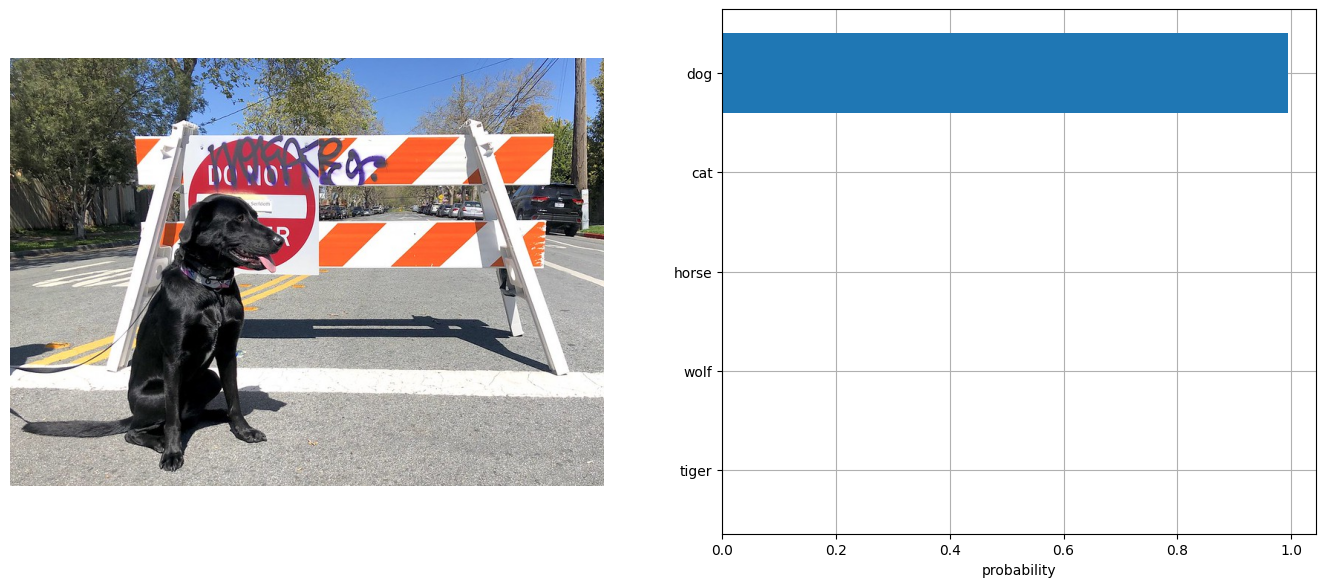

In [4]:
from urllib.request import urlretrieve
from pathlib import Path
import torch
from PIL import Image

image_path = Path("test_image.jpg")
urlretrieve(
    "https://storage.openvinotoolkit.org/repositories/openvino_notebooks/data/data/image/coco.jpg",
    image_path,
)
image = Image.open(image_path)

input_labels = ['cat', 'dog', 'wolf', 'tiger', 'man', 'horse', 'frog', 'tree', 'house', 'computer']
text_descriptions = [f"This is a photo of a {label}" for label in input_labels]

inputs = processor(text=text_descriptions, images=[image], padding="max_length", return_tensors="pt")

with torch.no_grad():
    model.config.torchscript = False
    results = model(**inputs)

logits_per_image = results['logits_per_image']  # this is the image-text similarity score

probs = logits_per_image.softmax(dim=1).detach().numpy()
visualize_result(image, input_labels, probs[0])

## Convert model to OpenVINO Intermediate Representation (IR) format
[back to top ⬆️](#Table-of-contents:)

For best results with OpenVINO, it is recommended to convert the model to OpenVINO IR format. OpenVINO supports PyTorch via Model conversion API.
To convert the PyTorch model to OpenVINO IR format we will use `ov.convert_model` of [model conversion API](https://docs.openvino.ai/2023.3/openvino_docs_model_processing_introduction.html). The `ov.convert_model` Python function returns an OpenVINO Model object ready to load on the device and start making predictions. We can save it on disk for the next usage with `ov.save_model`.


In [ ]:
import openvino as ov

model.config.torchscript = True
ov_model = ov.convert_model(model, example_input=dict(inputs))

## Run OpenVINO model
[back to top ⬆️](#Table-of-contents:)

The steps for making predictions with the OpenVINO SigLIP model are similar to the PyTorch model. Let us check the model result using the same input data from the example above with PyTorch.

Select device from dropdown list for running inference using OpenVINO

In [ ]:
import ipywidgets as widgets

core = ov.Core()

device = widgets.Dropdown(
    options=core.available_devices + ["AUTO"],
    value='AUTO',
    description='Device:',
    disabled=False,
)

device

Run OpenVINO model

[{'dog': 0.99}, {'cat': 0.0}, {'horse': 0.0}, {'wolf': 0.0}, {'tiger': 0.0}]


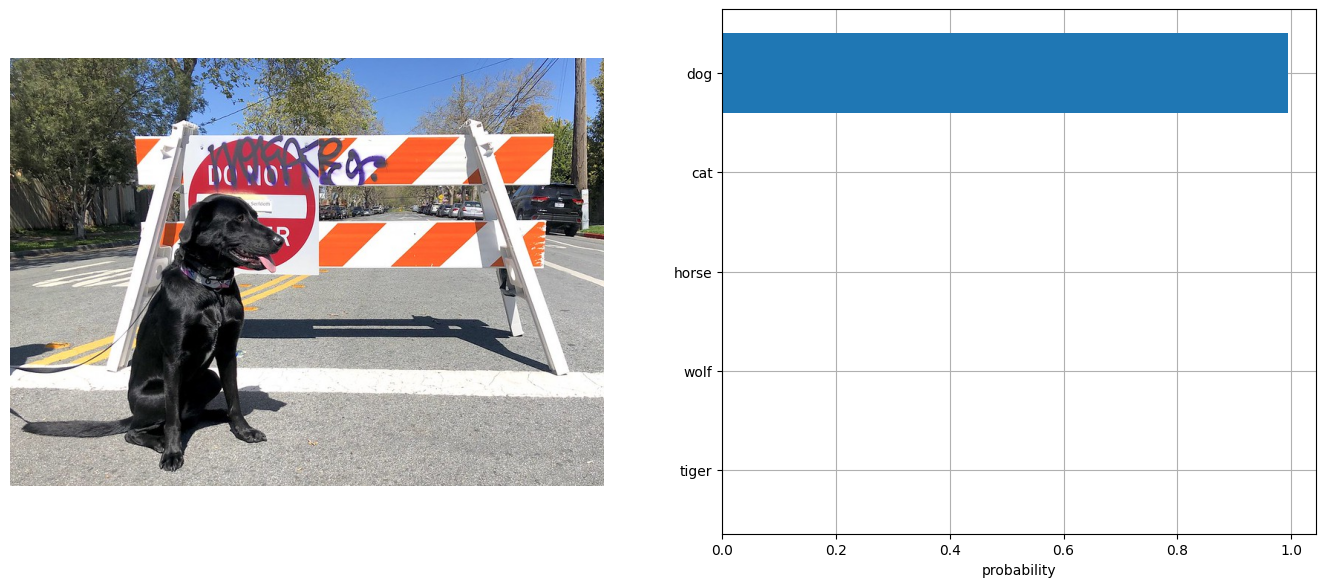

In [18]:
from scipy.special import softmax

# compile model for loading on device
compiled_ov_model = core.compile_model(ov_model, device.value)
# obtain output tensor for getting predictions
logits_per_image_out = compiled_ov_model.output(0)
# run inference on preprocessed data and get image-text similarity score
ov_logits_per_image = compiled_ov_model(dict(inputs))[logits_per_image_out]
# perform softmax on score
probs = softmax(ov_logits_per_image[0])
# visualize prediction
visualize_result(image, input_labels, probs)

Great! Looks like we got the same result.

## Apply post-training quantization using NNCF
[back to top ⬆️](#Table-of-contents:)

[NNCF](https://github.com/openvinotoolkit/nncf/) enables post-training quantization by adding the quantization layers into the model graph and then using a subset of the training dataset to initialize the parameters of these additional quantization layers. The framework is designed so that modifications to your original training code are minor. Quantization is the simplest scenario and requires a few modifications.

The optimization process contains the following steps:

1. Create a dataset for quantization.
1. Run `nncf.quantize` for getting a quantized model.

### Prepare dataset
[back to top ⬆️](#Table-of-contents:)

The [Conceptual Captions](https://ai.google.com/research/ConceptualCaptions/) dataset consisting of ~3.3M images annotated with captions is used to quantize model.

In [8]:
import requests
from io import BytesIO
from PIL import Image
from requests.packages.urllib3.exceptions import InsecureRequestWarning
requests.packages.urllib3.disable_warnings(InsecureRequestWarning)

def check_text_data(data):
    """
    Check if the given data is text-based.
    """
    if isinstance(data, str):
        return True
    if isinstance(data, list):
        return all(isinstance(x, str) for x in data)
    return False

def get_pil_from_url(url):
    """
    Downloads and converts an image from a URL to a PIL Image object.
    """
    response = requests.get(url, verify=False, timeout=20)
    image = Image.open(BytesIO(response.content))
    return image.convert("RGB")

def collate_fn(example, image_column="image_url", text_column="caption"):
    """
    Preprocesses an example by loading and transforming image and text data.
    Checks if the text data in the example is valid by calling the `check_text_data` function.
    Downloads the image specified by the URL in the image_column by calling the `get_pil_from_url` function.
    If there is any error during the download process, returns None.
    Returns the preprocessed inputs with transformed image and text data.
    """
    assert len(example) == 1
    example = example[0]

    if not check_text_data(example[text_column]):
        raise ValueError("Text data is not valid")

    url = example[image_column]
    try:
        image = get_pil_from_url(url)
        h, w = image.size
        if h == 1 or w == 1:
            return None
    except Exception:
        return None

    inputs = processor(text=example[text_column], images=[image], return_tensors="pt", padding="max_length")
    if inputs['input_ids'].shape[1] > model.config.text_config.max_position_embeddings:
        return None
    return inputs

In [9]:
import torch
from datasets import load_dataset
from tqdm.notebook import tqdm

def prepare_calibration_data(dataloader, init_steps):
    """
    This function prepares calibration data from a dataloader for a specified number of initialization steps.
    It iterates over the dataloader, fetching batches and storing the relevant data.
    """
    data = []
    print(f"Fetching {init_steps} for the initialization...")
    counter = 0
    for batch in tqdm(dataloader):
        if counter == init_steps:
            break
        if batch:
            counter += 1
            with torch.no_grad():
                data.append(
                    {
                        "pixel_values": batch["pixel_values"].to("cpu"),
                        "input_ids": batch["input_ids"].to("cpu"),
                    }
                )
    return data


def prepare_dataset(opt_init_steps=300, max_train_samples=1000):
    """
    Prepares a vision-text dataset for quantization.
    """
    dataset = load_dataset("conceptual_captions", streaming=True)
    train_dataset = dataset["train"].shuffle(seed=42, buffer_size=max_train_samples)
    dataloader = torch.utils.data.DataLoader(train_dataset, collate_fn=collate_fn, batch_size=1)
    calibration_data = prepare_calibration_data(dataloader, opt_init_steps)
    return calibration_data

In [ ]:
calibration_data = prepare_dataset()

### Quantize model
[back to top ⬆️](#Table-of-contents:)

Create a quantized model from the pre-trained `FP16` model.

> **NOTE**: Quantization is time and memory consuming operation. Running quantization code below may take a long time.

In [ ]:
import nncf
import logging

nncf.set_log_level(logging.ERROR)

if len(calibration_data) == 0:
    raise RuntimeError(
        'Calibration dataset is empty. Please check internet connection and try to download images manually.'
    )

calibration_dataset = nncf.Dataset(calibration_data)
quantized_ov_model = nncf.quantize(
    model=ov_model,
    calibration_dataset=calibration_dataset,
    model_type=nncf.ModelType.TRANSFORMER,
)

NNCF also supports quantization-aware training, and other algorithms than quantization.
See the [NNCF documentation](https://github.com/openvinotoolkit/nncf/#documentation) in the NNCF repository for more information.

### Run quantized OpenVINO model
[back to top ⬆️](#Table-of-contents:)

The steps for making predictions with the quantized OpenVINO SigLIP model are similar to the PyTorch model.

[{'dog': 0.99}, {'cat': 0.0}, {'horse': 0.0}, {'tiger': 0.0}, {'wolf': 0.0}]


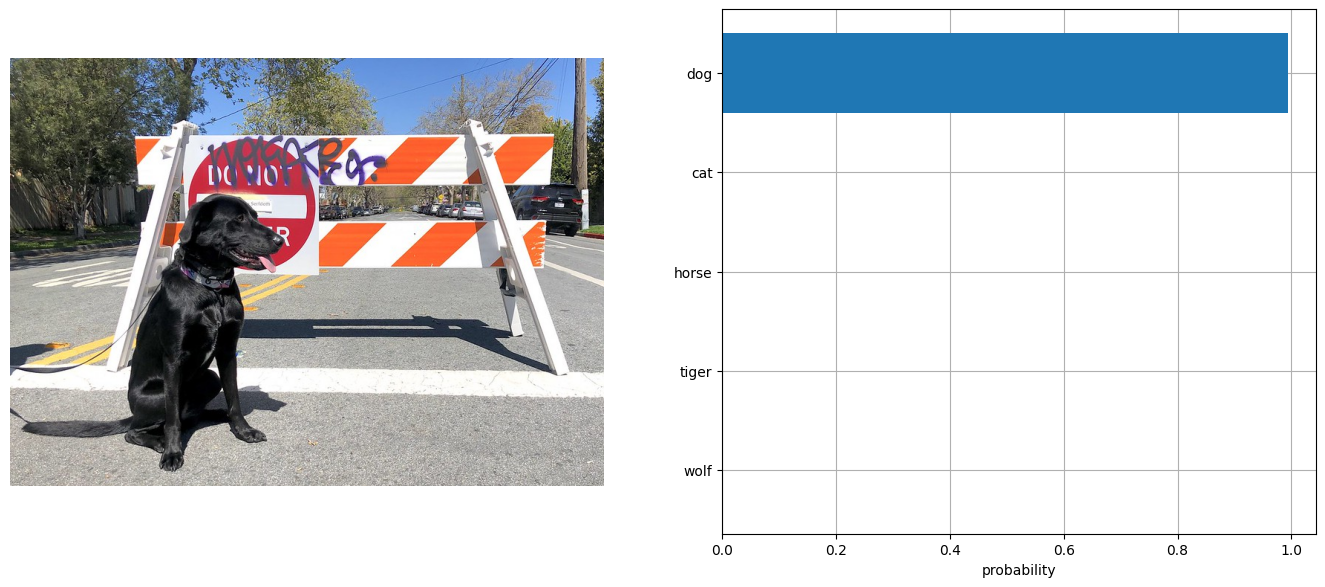

In [12]:
from pathlib import Path
from scipy.special import softmax


input_labels = ['cat', 'dog', 'wolf', 'tiger', 'man', 'horse', 'frog', 'tree', 'house', 'computer']
text_descriptions = [f"This is a photo of a {label}" for label in input_labels]

inputs = processor(text=text_descriptions, images=[image], return_tensors="pt", padding="max_length")
compiled_int8_ov_model = ov.compile_model(quantized_ov_model)

logits_per_image_out = compiled_int8_ov_model.output(0)
ov_logits_per_image = compiled_int8_ov_model(dict(inputs))[logits_per_image_out]
probs = softmax(ov_logits_per_image, axis=1)
visualize_result(image, input_labels, probs[0])

### Compare File Size
[back to top ⬆️](#Table-of-contents:)


In [13]:
from pathlib import Path

fp16_model_path = 'siglip-base-patch16-224.xml'
ov.save_model(ov_model, fp16_model_path)

int8_model_path = 'siglip-base-patch16-224_int8.xml'
ov.save_model(quantized_ov_model, int8_model_path)

fp16_ir_model_size = Path(fp16_model_path).with_suffix(".bin").stat().st_size / 1024 / 1024
quantized_model_size = Path(int8_model_path).with_suffix(".bin").stat().st_size / 1024 / 1024
print(f"FP16 IR model size: {fp16_ir_model_size:.2f} MB")
print(f"INT8 model size: {quantized_model_size:.2f} MB")
print(f"Model compression rate: {fp16_ir_model_size / quantized_model_size:.3f}")

FP16 IR model size: 387.49 MB
INT8 model size: 196.46 MB
Model compression rate: 1.972


### Compare inference time of the FP16 IR and quantized models
[back to top ⬆️](#Table-of-contents:)

To measure the inference performance of the `FP16` and `INT8` models, we use median inference time on calibration dataset.
So we can approximately estimate the speed up of the dynamic quantized models.


> **NOTE**: For the most accurate performance estimation, it is recommended to run `benchmark_app` in a terminal/command prompt after closing other applications with static shapes.

In [14]:
import time

def calculate_inference_time(model_path, calibration_data):
    model = ov.compile_model(model_path)
    output_layer = model.output(0)
    inference_time = []
    for batch in calibration_data:
        start = time.perf_counter()
        _ = model(batch)[output_layer]
        end = time.perf_counter()
        delta = end - start
        inference_time.append(delta)
    return np.median(inference_time)

In [16]:
fp16_latency = calculate_inference_time(fp16_model_path, calibration_data)
int8_latency = calculate_inference_time(int8_model_path, calibration_data)
print(f"Performance speed up: {fp16_latency / int8_latency:.3f}")

Performance speed up: 2.827


## Interactive inference

[back to top ⬆️](#Table-of-contents:)

Now, it is your turn! You can provide your own image and comma-separated list of labels for zero-shot classification.
Feel free to upload an image, using the file upload window and type label names into the text field, using comma as the separator (for example, `cat,dog,bird`)

In [ ]:
import gradio as gr


def classify(image, text):
    """Classify image using classes listing.
    Args:
        image (np.ndarray): image that needs to be classified in CHW format.
        text (str): comma-separated list of class labels
    Returns:
        (dict): Mapping between class labels and class probabilities.
    """
    labels = text.split(",")
    text_descriptions = [f"This is a photo of a {label}" for label in labels]
    inputs = processor(
        text=text_descriptions,
        images=[image],
        return_tensors="np",
        padding="max_length",
    )
    ov_logits_per_image = compiled_ov_model(dict(inputs))[logits_per_image_out]
    probs = softmax(ov_logits_per_image[0])

    return {label: float(prob) for label, prob in zip(labels, probs)}


demo = gr.Interface(
    classify,
    [
        gr.Image(label="Image", type="pil"),
        gr.Textbox(label="Labels", info="Comma-separated list of class labels"),
    ],
    gr.Label(label="Result"),
    examples=[[image_path, "cat,dog,bird"]],
)
try:
    demo.launch(debug=True, height=1000)
except Exception:
    demo.launch(share=True, debug=True, height=1000)
# if you are launching remotely, specify server_name and server_port
# demo.launch(server_name='your server name', server_port='server port in int')
# Read more in the docs: https://gradio.app/docs/